Import Libraries

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unidecode
import joblib
import warnings
import shap
import lime
import lime.lime_tabular
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, auc, classification_report,
    make_scorer, r2_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import load_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

1 Data Preprocesing

In [ ]:


# ========== 1. TABULAR DATA PREPROCESSING ==========
def preprocess_tabular_dataset(df, scaler_svm=None, scaler_rnn=None, fit_scalers=True):
    df = df.copy()
    df = df[df["CLAVEEDAD"] == 5].copy()

    base_columns = [
        "SEXO", "SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA", "EDAD",
        "ESTADOCONYUGAL", "ESCOLARIDAD", "CLAVEOCUPACIONHABITUAL",
        "TRABAJAACTUALMENTE", "AFILIACION", "MUNICIPIORESIDENCIAD",
        "CODIGOPOSTALRESIDENCIA", "TIPOASENTAMIENTORESIDENCIA"
    ]
    descripcion_columns = [col for col in df.columns if "DESCRIPCIONCAUSA" in col]
    all_columns = base_columns + descripcion_columns
    df_cleaned = df[all_columns].copy()

    # Fill missing values
    for col in ["SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA"]:
        df_cleaned[col] = df_cleaned[col].fillna("Unknown")

    # Keep raw municipio name for fusion
    df_cleaned["Municipio_raw"] = df_cleaned["MUNICIPIORESIDENCIAD"]

    # Scale EDAD
    if fit_scalers:
        scaler_svm = StandardScaler()
        scaler_rnn = MinMaxScaler()
        df_cleaned["EDAD_SVM"] = scaler_svm.fit_transform(df_cleaned[["EDAD"]])
        df_cleaned["EDAD_RNN"] = scaler_rnn.fit_transform(df_cleaned[["EDAD"]])
    else:
        df_cleaned["EDAD_SVM"] = scaler_svm.transform(df_cleaned[["EDAD"]])
        df_cleaned["EDAD_RNN"] = scaler_rnn.transform(df_cleaned[["EDAD"]])

    # Encode categoricals
    categorical_columns = [
        "SEXO", "SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA", "ESTADOCONYUGAL", 
        "ESCOLARIDAD", "CLAVEOCUPACIONHABITUAL", "TRABAJAACTUALMENTE", "AFILIACION", 
        "MUNICIPIORESIDENCIAD", "CODIGOPOSTALRESIDENCIA", "TIPOASENTAMIENTORESIDENCIA"
    ]

    for col in categorical_columns:
        df_cleaned[col] = LabelEncoder().fit_transform(df_cleaned[col].astype(str))

    # Target label creation
    def contains_renal(text):
        if pd.isna(text):
            return 0
        return int(any(word in text.lower() for word in ["renal", "renales", "riñon"]))

    df_cleaned["RENAL_RELATED"] = df_cleaned[descripcion_columns].apply(
        lambda row: max(row.apply(contains_renal)), axis=1
    )

    df_ml = df_cleaned.drop(columns=descripcion_columns).copy()
    df_ml["target"] = df_ml.pop("RENAL_RELATED")

    return df_cleaned, df_ml, scaler_svm, scaler_rnn


# ========== 2. GEOSPATIAL PREPROCESSING ==========
def preprocess_geodata(input_path, output_path, columns_to_keep, categorical_columns, estado_filter=None, plot_title=None, color=None):
    print(f"\n📂 Loading: {input_path}")
    gdf = gpd.read_file(input_path)

    if estado_filter and 'Estado' in gdf.columns:
        gdf = gdf[gdf['Estado'].str.upper() == estado_filter.upper()].copy()
        print(f"✅ Filtered by Estado == {estado_filter.upper()}")

    # Save raw municipio name for fusion
    if 'Municipio' in gdf.columns:
        gdf["Municipio_raw"] = gdf["Municipio"]

    gdf = gdf[columns_to_keep].copy()

    for col in categorical_columns:
        gdf[col] = LabelEncoder().fit_transform(gdf[col].astype(str))

    gdf.to_file(output_path, driver="GPKG")
    print(f"💾 Saved cleaned data to: {output_path}")

    if plot_title:
        fig, ax = plt.subplots()
        gdf.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3)
        ax.set_title(plot_title)
        plt.axis("off")
        plt.show()

    return gdf


# ========== 3. EARLY FUSION ==========
def normalize_municipio(name):
    try:
        name = str(name)
        name = unidecode.unidecode(name)
        name = re.sub(r"\(.*\)", "", name)
        return name.strip().lower()
    except:
        return ""


def perform_fusion(gdf, df_tabular):
    gdf["Municipio_merge"] = gdf["Municipio_raw"].apply(normalize_municipio)
    df_tabular["Municipio_merge"] = df_tabular["Municipio_raw"].apply(normalize_municipio)

    df_merged = gdf.merge(
        df_tabular,
        on="Municipio_merge",
        how="inner"
    )

    print(f"✅ Final fused dataset shape: {df_merged.shape}")
    return df_merged


# ==================== MAIN WORKFLOW ====================

# --- Load and preprocess tabular data ---
df_raw = pd.read_csv("mort_2022-23.csv")
df_cleaned, df_ml, scaler_svm, scaler_rnn = preprocess_tabular_dataset(df_raw)

# --- Geospatial preprocessing ---
gdf_hid = preprocess_geodata(
    input_path="hid.gpkg",
    output_path="Hid_Jalisco_Cleaned.gpkg",
    columns_to_keep=[
        'Clave Región Hidrológica', 'Clave Cuenca', 'Clave Subcuenca',
        'Clave Microcuenca', 'Elevación en m.', 'Municipio', 'Clima', 'geometry', 'Municipio_raw'
    ],
    categorical_columns=[
        'Clave Región Hidrológica', 'Clave Cuenca', 'Clave Subcuenca',
        'Clave Microcuenca', 'Municipio', 'Clima'
    ],
    estado_filter="JALISCO",
    plot_title="🌀 Hidráulico Data (Jalisco)",
    color="skyblue"
)

gdf_up = preprocess_geodata(
    input_path="up.gpkg",
    output_path="UP_Jalisco_Cleaned.gpkg",
    columns_to_keep=['Clave Uso Predominante', 'Fragilidad', 'geometry'],
    categorical_columns=['Clave Uso Predominante', 'Fragilidad'],
    estado_filter=None,
    plot_title="🌾 Uso Predominante Data",
    color="lightgreen"
)

# --- Spatial join ---
if gdf_hid.crs != gdf_up.crs:
    gdf_up = gdf_up.to_crs(gdf_hid.crs)

gdf_merged_geo = gpd.sjoin(gdf_hid, gdf_up, how="inner", predicate="intersects").drop(columns="index_right")
gdf_merged_geo.to_file("Merged_Hid_UP_Jalisco.gpkg", driver="GPKG")

# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 8))
gdf_hid.plot(ax=ax, color="skyblue", label="Hidráulico", edgecolor='gray', alpha=0.5)
gdf_up.plot(ax=ax, color="lightgreen", label="Uso Predominante", edgecolor='darkgreen', alpha=0.5)
gdf_merged_geo.plot(ax=ax, color="orange", label="Merged", edgecolor='black', alpha=0.7)
plt.title("🧩 Merged Hidráulico + UP Data (Jalisco)")
plt.axis("off")
plt.legend()
plt.show()

# --- Final fusion with tabular data ---
df_fused = perform_fusion(gdf_merged_geo, df_cleaned)
df_fused.to_file("Final_Fused_Dataset.gpkg", driver="GPKG")


/var/folders/jr/v95j2nsj1d5_lz3mjy5x_pr40000gn/T/ipykernel_8652/4067438483.py:2: DtypeWarning: Columns (62,69,75,76,83,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("mort_2022-23.csv")


In [2]:
gdf = gpd.read_file("Final_Fused_Dataset.gpkg")
df = gdf.drop(columns="geometry").copy()

NameError: name 'gpd' is not defined

2 Model Training

Running Cross-Validation...

Training Decision Tree...
Decision Tree: Mean F1 = 0.5235 ± 0.0036
Training Random Forest...
Random Forest: Mean F1 = 0.4971 ± 0.0012
Training AdaBoost...
AdaBoost: Mean F1 = 0.4642 ± 0.0000
Training SVM...
SVM: Mean F1 = 0.3163 ± 0.0023
Training XGBoost...
XGBoost: Mean F1 = 0.5671 ± 0.0033
Training Naïve Bayes...
Naïve Bayes: Mean F1 = 0.4642 ± 0.0000
Training GBM...
GBM: Mean F1 = 0.4643 ± 0.0002
RNN: Mean F1 = 0.4642 ± 0.0000


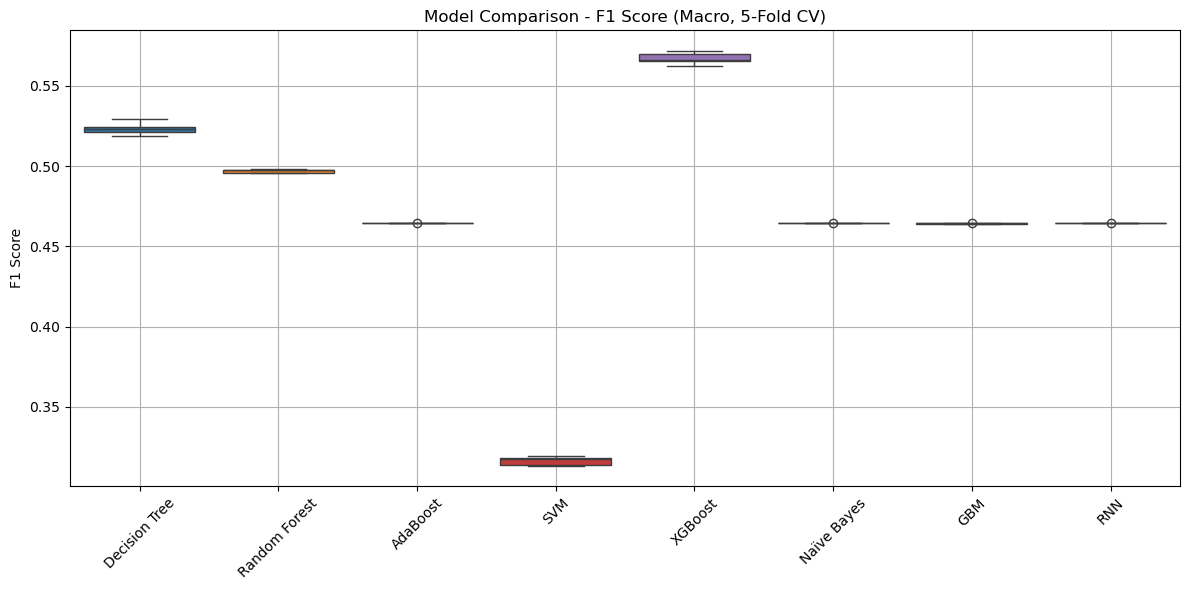


Evaluating models on test set:


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86    114953
           1       0.16      0.17      0.16     18276

    accuracy                           0.76    133229
   macro avg       0.51      0.51      0.51    133229
weighted avg       0.77      0.76      0.76    133229


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93    114953
           1       0.35      0.01      0.03     18276

    accuracy                           0.86    133229
   macro avg       0.61      0.50      0.48    133229
weighted avg       0.79      0.86      0.80    133229


AdaBoost Performance:
              precision    recall  f1-score   support

           0       0.86      1.00      0.93    114953
           1       0.00      0.00      0.00     18276

    accuracy                           0.86    133229
   macro avg    

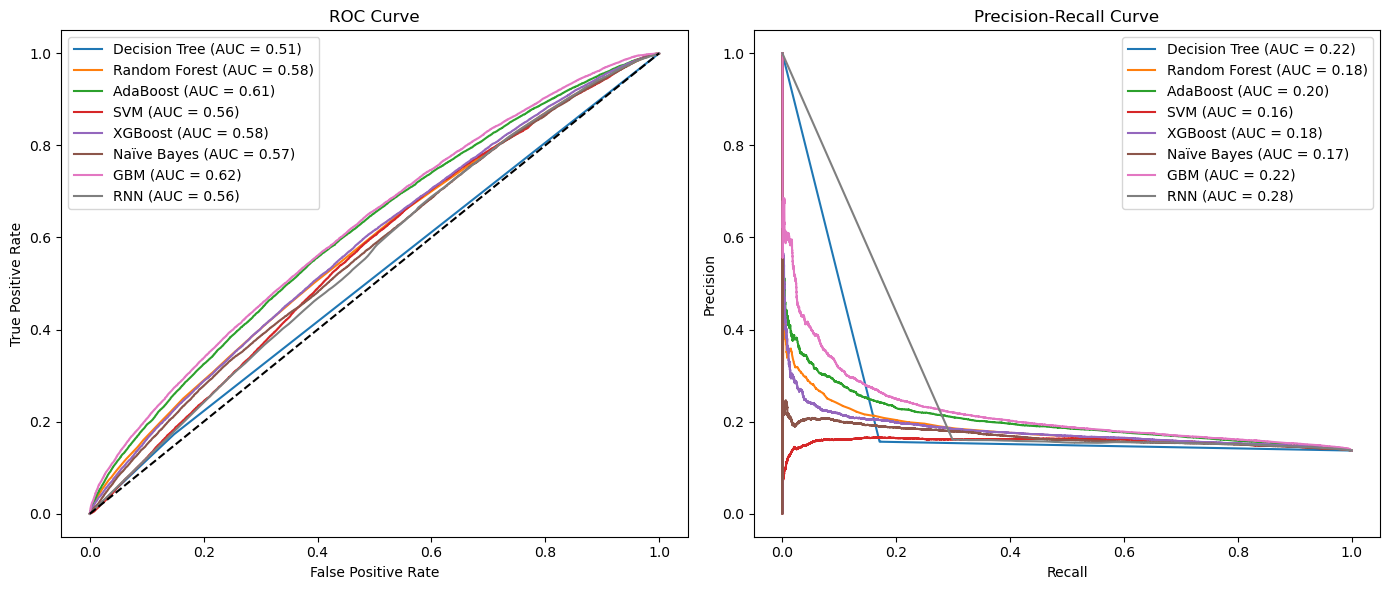


✅ Best model saved: SVM → 'SVM_best_model.pkl'


In [ ]:
warnings.filterwarnings("ignore")

# --------------------------
# Load Fused Dataset
# --------------------------

gdf = gpd.read_file("Final_Fused_Dataset.gpkg")
df = gdf.drop(columns="geometry").copy()

# --------------------------
# Train/Test Split
# --------------------------

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# SVM Feature Set
X_train_svm = X_train.copy()
X_train_svm["EDAD"] = X_train["EDAD_SVM"]

X_test_svm = X_test.copy()
X_test_svm["EDAD"] = X_test["EDAD_SVM"]

# RNN Feature Set
X_train_rnn = X_train[["EDAD_RNN"]].values
X_test_rnn = X_test[["EDAD_RNN"]].values

# --------------------------
# Class Weights
# --------------------------

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# --------------------------
# Traditional Models
# --------------------------

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                             scale_pos_weight=class_weight_dict[1]),
    "Naïve Bayes": GaussianNB(),
    "GBM": GradientBoostingClassifier(random_state=42)
}

# --------------------------
# Cross-Validation
# --------------------------

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='macro')
cv_results = {}

print("Running Cross-Validation...\n")

for name, model in models.items():
    print(f"Training {name}...")
    X_input = X_train_svm if name == "SVM" else X_train
    scores = cross_val_score(model, X_input, y_train, cv=cv, scoring=scorer)
    cv_results[name] = scores
    print(f"{name}: Mean F1 = {scores.mean():.4f} ± {scores.std():.4f}")

# --------------------------
# RNN Model
# --------------------------

def build_rnn_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = KerasClassifier(
    model=build_rnn_model,
    model__input_dim=X_train_rnn.shape[1],
    epochs=30,
    batch_size=32,
    verbose=0
)
rnn_scores = cross_val_score(rnn_model, X_train_rnn, y_train, cv=cv, scoring=scorer)
cv_results["RNN"] = rnn_scores
print(f"RNN: Mean F1 = {rnn_scores.mean():.4f} ± {rnn_scores.std():.4f}")

# --------------------------
# Test Set Evaluation
# --------------------------

evaluation_results = {}
f1_scores = {}

print("\nEvaluating models on test set:\n")

for name, model in models.items():
    model.fit(X_train_svm if name == "SVM" else X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    prc_prec, prc_rec, _ = precision_recall_curve(y_test, y_proba)
    prc_auc = auc(prc_rec, prc_prec)

    evaluation_results[name] = {
        "Accuracy": acc, "Precision": prec, "Recall": rec,
        "F1-Score": f1, "ROC AUC": roc_auc, "PR AUC": prc_auc
    }
    f1_scores[name] = f1

    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))

# --------------------------
# RNN Final Evaluation
# --------------------------

rnn_final = build_rnn_model(X_train_rnn.shape[1])
rnn_final.fit(X_train_rnn, y_train, epochs=30, batch_size=32, verbose=0)
y_pred_rnn = (rnn_final.predict(X_test_rnn) > 0.5).astype(int).flatten()
y_proba_rnn = rnn_final.predict(X_test_rnn).flatten()

acc = accuracy_score(y_test, y_pred_rnn)
prec = precision_score(y_test, y_pred_rnn, zero_division=0)
rec = recall_score(y_test, y_pred_rnn)
f1 = f1_score(y_test, y_pred_rnn)
roc_auc = roc_auc_score(y_test, y_proba_rnn)
prc_prec, prc_rec, _ = precision_recall_curve(y_test, y_proba_rnn)
prc_auc = auc(prc_rec, prc_prec)

evaluation_results["RNN"] = {
    "Accuracy": acc, "Precision": prec, "Recall": rec,
    "F1-Score": f1, "ROC AUC": roc_auc, "PR AUC": prc_auc
}
f1_scores["RNN"] = f1

print("\nRNN Performance:")
print(classification_report(y_test, y_pred_rnn))

# --------------------------
# ROC & PR Curve
# --------------------------

plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
for name in evaluation_results:
    y_proba = rnn_final.predict(X_test_rnn).flatten() if name == "RNN" else (
        models[name].predict_proba(X_test)[:, 1] if hasattr(models[name], "predict_proba")
        else models[name].decision_function(X_test)
    )
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
for name in evaluation_results:
    y_proba = rnn_final.predict(X_test_rnn).flatten() if name == "RNN" else (
        models[name].predict_proba(X_test)[:, 1] if hasattr(models[name], "predict_proba")
        else models[name].decision_function(X_test)
    )
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

# --------------------------
# Custom CKD Score & Save Best
# --------------------------

def ckd_score(metrics, recall_weight=0.8, pr_auc_weight=0.2):
    return recall_weight * metrics["Recall"] + pr_auc_weight * metrics["PR AUC"]

ckd_scores = {name: ckd_score(metrics) for name, metrics in evaluation_results.items()}
best_model_name = max(ckd_scores, key=ckd_scores.get)

if best_model_name != "RNN":
    best_model = models[best_model_name]
    best_model.fit(X_train, y_train)
    joblib.dump(best_model, f"{best_model_name.replace(' ', '_')}_best_model.pkl")
    print(f"\n✅ Best model saved: {best_model_name} → {best_model_name.replace(' ', '_')}_best_model.pkl")
else:
    rnn_final.save("RNN_best_model.h5")
    print("\n✅ Best model is RNN → saved as 'RNN_best_model.h5'")


3 Explainability Analysis 

In [ ]:

# -------------------------------
# Step 1: Load model and preprocess test set
# -------------------------------

model = joblib.load("SVM_best_model.pkl")

# Reload and preprocess
df_train_raw = pd.read_csv("mort_2022-23.csv")
df_test_raw = pd.read_csv("mort_2020_21.csv")

_, df_train_ml, scaler_svm, scaler_rnn = preprocess_dataset(df_train_raw)
_, df_test_ml, _, _ = preprocess_dataset(df_test_raw, scaler_svm, scaler_rnn, fit_scalers=False)

# Prepare SVM inputs
X_test = df_test_ml.drop(columns=["target"]).copy()
X_test["EDAD"] = df_test_ml["EDAD_SVM"]
y_test = df_test_ml["target"]

# -------------------------------
# Step 2: SHAP with KernelExplainer
# -------------------------------

print("📊 SHAP Summary Plot (KernelExplainer for SVM)")

# Use a small sample for background (to keep KernelExplainer fast)
X_background = shap.utils.sample(X_test, 100, random_state=42)

# Create explainer
explainer_shap = shap.KernelExplainer(model.predict_proba, X_background)
shap_values = explainer_shap.shap_values(X_test, nsamples=100)

# Plot for class 1 (renal-related)
shap.summary_plot(shap_values[1], X_test)

# -------------------------------
# Step 3: LIME Local Explanation
# -------------------------------

print("💬 LIME Explanation for one prediction")

X_lime = X_test.values
feature_names = X_test.columns.tolist()

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_lime,
    feature_names=feature_names,
    class_names=["No Renal", "Renal"],
    mode="classification"
)

# Explain one prediction
idx = 10
exp = lime_explainer.explain_instance(
    data_row=X_lime[idx],
    predict_fn=model.predict_proba,
    num_features=5
)

exp.show_in_notebook()

# -------------------------------
# Step 4: Fidelity, Interpretability, FII
# -------------------------------

fidelity = exp.score
interpretability = len(exp.as_list())
fii = fidelity / (1 + interpretability)

print(f"\n🧠 Fidelity (R²): {fidelity:.4f}")
print(f"📉 Interpretability (features used): {interpretability}")
print(f"📈 Fidelity-Interpretability Index (FII): {fii:.4f}")

# -------------------------------
# Step 5: Plot Metrics
# -------------------------------

plt.figure(figsize=(6, 4))
sns.barplot(x=["Fidelity", "Interpretability", "FII"],
            y=[fidelity, interpretability, fii],
            palette=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.title("XAI Evaluation Metrics (LIME)")
plt.tight_layout()
plt.show()


/var/folders/jr/v95j2nsj1d5_lz3mjy5x_pr40000gn/T/ipykernel_19240/3392776894.py:8: DtypeWarning: Columns (62,69,75,76,83,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_raw = pd.read_csv("mort_2022-23.csv")
/var/folders/jr/v95j2nsj1d5_lz3mjy5x_pr40000gn/T/ipykernel_19240/3392776894.py:9: DtypeWarning: Columns (13,15,69,76,89,90,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_raw = pd.read_csv("mort_2020_21.csv")


📊 SHAP Summary Plot (KernelExplainer for SVM)


  0%|          | 0/133229 [00:00<?, ?it/s]

4  Interpretability & Visualization

In [ ]:
#(Heatmaps, Decision Paths, Partial Dependence)

Geodata

In [3]:


# Keep a raw copy of the name BEFORE encoding for fusion
gdf["Municipio_raw"] = gdf["Municipio"]

def preprocess_geodata(input_path, output_path, columns_to_keep, categorical_columns, estado_filter=None, plot_title=None, color=None):
    """
    Preprocess a GeoPackage file and optionally visualize it.

    Parameters:
        input_path (str): Path to input GeoPackage.
        output_path (str): Path to save the cleaned output.
        columns_to_keep (list): Columns to retain (must include 'geometry').
        categorical_columns (list): Columns to encode with LabelEncoder.
        estado_filter (str): Optional filter for the 'Estado' column.
        plot_title (str): Optional title for visualization.
        color (str): Optional color for plotting.

    Returns:
        gdf (GeoDataFrame): Preprocessed GeoDataFrame.
    """
    print(f"\n📂 Loading: {input_path}")
    gdf = gpd.read_file(input_path)

    if estado_filter and 'Estado' in gdf.columns:
        gdf = gdf[gdf['Estado'].str.upper() == estado_filter.upper()].copy()
        print(f"✅ Filtered by Estado == {estado_filter.upper()}")

    gdf = gdf[columns_to_keep].copy()

    for col in categorical_columns:
        gdf[col] = LabelEncoder().fit_transform(gdf[col].astype(str))

    gdf.to_file(output_path, driver="GPKG")
    print(f"💾 Saved cleaned data to: {output_path}")

    if plot_title:
        fig, ax = plt.subplots()
        gdf.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3)
        ax.set_title(plot_title)
        plt.axis("off")
        plt.show()

    print(f"🧱 Columns:\n{gdf.dtypes}")
    print(gdf.head())
    return gdf


# === Preprocess Hidráulico dataset ===
gdf_hid = preprocess_geodata(
    input_path="hid.gpkg",
    output_path="Hid_Jalisco_Cleaned.gpkg",
    columns_to_keep=[
        'Clave Región Hidrológica', 'Clave Cuenca', 'Clave Subcuenca',
        'Clave Microcuenca', 'Elevación en m.', 'Municipio', 'Clima', 'geometry'
    ],
    categorical_columns=[
        'Clave Región Hidrológica', 'Clave Cuenca', 'Clave Subcuenca',
        'Clave Microcuenca', 'Municipio', 'Clima'
    ],
    estado_filter="JALISCO",
    plot_title="🌀 Hidráulico Data (Jalisco)",
    color="skyblue"
)

# === Preprocess Uso Predominante dataset ===
gdf_up = preprocess_geodata(
    input_path="up.gpkg",
    output_path="UP_Jalisco_Cleaned.gpkg",
    columns_to_keep=['Clave Uso Predominante', 'Fragilidad', 'geometry'],
    categorical_columns=['Clave Uso Predominante', 'Fragilidad'],
    estado_filter=None,
    plot_title="🌾 Uso Predominante Data",
    color="lightgreen"
)

# === Reload cleaned datasets ===
gdf_hid = gpd.read_file("Hid_Jalisco_Cleaned.gpkg")
gdf_up = gpd.read_file("UP_Jalisco_Cleaned.gpkg")

# === Ensure same CRS ===
if gdf_hid.crs != gdf_up.crs:
    gdf_up = gdf_up.to_crs(gdf_hid.crs)

# === Spatial join ===
print("\n🔗 Performing spatial join (intersects)...")
gdf_merged = gpd.sjoin(gdf_hid, gdf_up, how="inner", predicate="intersects").drop(columns="index_right")
gdf_merged.to_file("Merged_Hid_UP_Jalisco.gpkg", driver="GPKG")
print("✅ Saved merged dataset: Merged_Hid_UP_Jalisco.gpkg")

# === Visualize merged dataset with a different color ===
fig, ax = plt.subplots(figsize=(10, 8))
gdf_hid.plot(ax=ax, color="skyblue", label="Hidráulico", edgecolor='gray', alpha=0.5)
gdf_up.plot(ax=ax, color="lightgreen", label="Uso Predominante", edgecolor='darkgreen', alpha=0.5)
gdf_merged.plot(ax=ax, color="orange", label="Merged", edgecolor='black', alpha=0.7)

plt.title("🧩 Merged Hidráulico + UP Data (Jalisco)")
plt.axis("off")
plt.legend()
plt.show()

# === Output final info ===
print("📊 Final Merged GeoDataFrame:")
print(gdf_merged.head())




NameError: name 'gdf' is not defined

/var/folders/jr/v95j2nsj1d5_lz3mjy5x_pr40000gn/T/ipykernel_17955/1420775714.py:118: DtypeWarning: Columns (62,69,75,76,83,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("mort_2022-23.csv")



📂 Loading: hid.gpkg
✅ Filtered by Estado == JALISCO
💾 Saved cleaned data to: Hid_Jalisco_Cleaned.gpkg


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


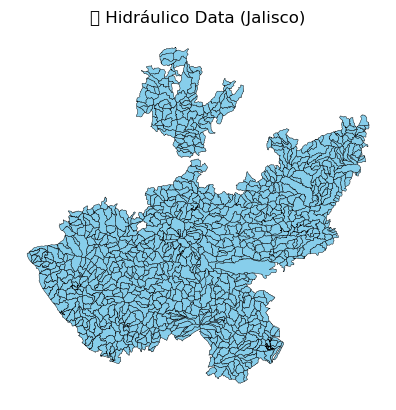


📂 Loading: up.gpkg
💾 Saved cleaned data to: UP_Jalisco_Cleaned.gpkg


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127806 (\N{EAR OF RICE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


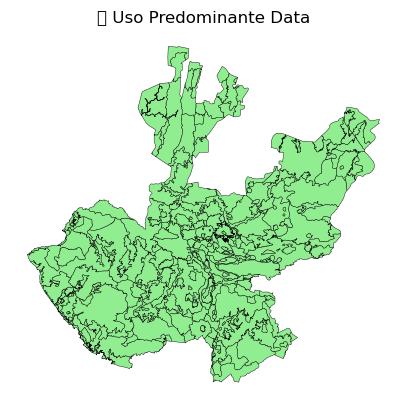

/var/folders/jr/v95j2nsj1d5_lz3mjy5x_pr40000gn/T/ipykernel_17955/1420775714.py:162: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


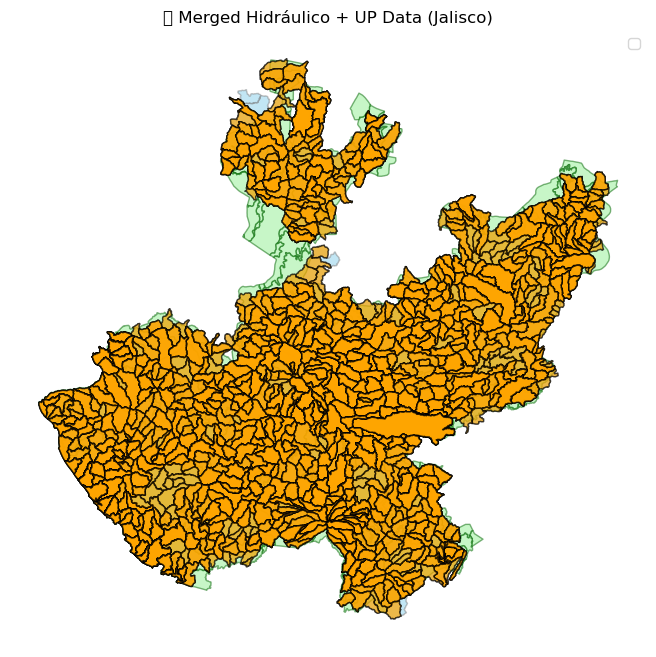

✅ Final fused dataset shape: (2800108, 34)


In [6]:


# ========== 1. TABULAR DATA PREPROCESSING ==========
def preprocess_tabular_dataset(df, scaler_svm=None, scaler_rnn=None, fit_scalers=True):
    df = df.copy()
    df = df[df["CLAVEEDAD"] == 5].copy()

    base_columns = [
        "SEXO", "SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA", "EDAD",
        "ESTADOCONYUGAL", "ESCOLARIDAD", "CLAVEOCUPACIONHABITUAL",
        "TRABAJAACTUALMENTE", "AFILIACION", "MUNICIPIORESIDENCIAD",
        "CODIGOPOSTALRESIDENCIA", "TIPOASENTAMIENTORESIDENCIA"
    ]
    descripcion_columns = [col for col in df.columns if "DESCRIPCIONCAUSA" in col]
    all_columns = base_columns + descripcion_columns
    df_cleaned = df[all_columns].copy()

    # Fill missing values
    for col in ["SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA"]:
        df_cleaned[col] = df_cleaned[col].fillna("Unknown")

    # Keep raw municipio name for fusion
    df_cleaned["Municipio_raw"] = df_cleaned["MUNICIPIORESIDENCIAD"]

    # Scale EDAD
    if fit_scalers:
        scaler_svm = StandardScaler()
        scaler_rnn = MinMaxScaler()
        df_cleaned["EDAD_SVM"] = scaler_svm.fit_transform(df_cleaned[["EDAD"]])
        df_cleaned["EDAD_RNN"] = scaler_rnn.fit_transform(df_cleaned[["EDAD"]])
    else:
        df_cleaned["EDAD_SVM"] = scaler_svm.transform(df_cleaned[["EDAD"]])
        df_cleaned["EDAD_RNN"] = scaler_rnn.transform(df_cleaned[["EDAD"]])

    # Encode categoricals
    categorical_columns = [
        "SEXO", "SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA", "ESTADOCONYUGAL", 
        "ESCOLARIDAD", "CLAVEOCUPACIONHABITUAL", "TRABAJAACTUALMENTE", "AFILIACION", 
        "MUNICIPIORESIDENCIAD", "CODIGOPOSTALRESIDENCIA", "TIPOASENTAMIENTORESIDENCIA"
    ]

    for col in categorical_columns:
        df_cleaned[col] = LabelEncoder().fit_transform(df_cleaned[col].astype(str))

    # Target label creation
    def contains_renal(text):
        if pd.isna(text):
            return 0
        return int(any(word in text.lower() for word in ["renal", "renales", "riñon"]))

    df_cleaned["RENAL_RELATED"] = df_cleaned[descripcion_columns].apply(
        lambda row: max(row.apply(contains_renal)), axis=1
    )

    df_ml = df_cleaned.drop(columns=descripcion_columns).copy()
    df_ml["target"] = df_ml.pop("RENAL_RELATED")

    return df_cleaned, df_ml, scaler_svm, scaler_rnn


# ========== 2. GEOSPATIAL PREPROCESSING ==========
def preprocess_geodata(input_path, output_path, columns_to_keep, categorical_columns, estado_filter=None, plot_title=None, color=None):
    print(f"\n📂 Loading: {input_path}")
    gdf = gpd.read_file(input_path)

    if estado_filter and 'Estado' in gdf.columns:
        gdf = gdf[gdf['Estado'].str.upper() == estado_filter.upper()].copy()
        print(f"✅ Filtered by Estado == {estado_filter.upper()}")

    # Save raw municipio name for fusion
    if 'Municipio' in gdf.columns:
        gdf["Municipio_raw"] = gdf["Municipio"]

    gdf = gdf[columns_to_keep].copy()

    for col in categorical_columns:
        gdf[col] = LabelEncoder().fit_transform(gdf[col].astype(str))

    gdf.to_file(output_path, driver="GPKG")
    print(f"💾 Saved cleaned data to: {output_path}")

    if plot_title:
        fig, ax = plt.subplots()
        gdf.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3)
        ax.set_title(plot_title)
        plt.axis("off")
        plt.show()

    return gdf


# ========== 3. EARLY FUSION ==========
def normalize_municipio(name):
    try:
        name = str(name)
        name = unidecode.unidecode(name)
        name = re.sub(r"\(.*\)", "", name)
        return name.strip().lower()
    except:
        return ""


def perform_fusion(gdf, df_tabular):
    gdf["Municipio_merge"] = gdf["Municipio_raw"].apply(normalize_municipio)
    df_tabular["Municipio_merge"] = df_tabular["Municipio_raw"].apply(normalize_municipio)

    df_merged = gdf.merge(
        df_tabular,
        on="Municipio_merge",
        how="inner"
    )

    print(f"✅ Final fused dataset shape: {df_merged.shape}")
    return df_merged


# ==================== MAIN WORKFLOW ====================

# --- Load and preprocess tabular data ---
df_raw = pd.read_csv("mort_2022-23.csv")
df_cleaned, df_ml, scaler_svm, scaler_rnn = preprocess_tabular_dataset(df_raw)

# --- Geospatial preprocessing ---
gdf_hid = preprocess_geodata(
    input_path="hid.gpkg",
    output_path="Hid_Jalisco_Cleaned.gpkg",
    columns_to_keep=[
        'Clave Región Hidrológica', 'Clave Cuenca', 'Clave Subcuenca',
        'Clave Microcuenca', 'Elevación en m.', 'Municipio', 'Clima', 'geometry', 'Municipio_raw'
    ],
    categorical_columns=[
        'Clave Región Hidrológica', 'Clave Cuenca', 'Clave Subcuenca',
        'Clave Microcuenca', 'Municipio', 'Clima'
    ],
    estado_filter="JALISCO",
    plot_title="🌀 Hidráulico Data (Jalisco)",
    color="skyblue"
)

gdf_up = preprocess_geodata(
    input_path="up.gpkg",
    output_path="UP_Jalisco_Cleaned.gpkg",
    columns_to_keep=['Clave Uso Predominante', 'Fragilidad', 'geometry'],
    categorical_columns=['Clave Uso Predominante', 'Fragilidad'],
    estado_filter=None,
    plot_title="🌾 Uso Predominante Data",
    color="lightgreen"
)

# --- Spatial join ---
if gdf_hid.crs != gdf_up.crs:
    gdf_up = gdf_up.to_crs(gdf_hid.crs)

gdf_merged_geo = gpd.sjoin(gdf_hid, gdf_up, how="inner", predicate="intersects").drop(columns="index_right")
gdf_merged_geo.to_file("Merged_Hid_UP_Jalisco.gpkg", driver="GPKG")

# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 8))
gdf_hid.plot(ax=ax, color="skyblue", label="Hidráulico", edgecolor='gray', alpha=0.5)
gdf_up.plot(ax=ax, color="lightgreen", label="Uso Predominante", edgecolor='darkgreen', alpha=0.5)
gdf_merged_geo.plot(ax=ax, color="orange", label="Merged", edgecolor='black', alpha=0.7)
plt.title("🧩 Merged Hidráulico + UP Data (Jalisco)")
plt.axis("off")
plt.legend()
plt.show()

# --- Final fusion with tabular data ---
df_fused = perform_fusion(gdf_merged_geo, df_cleaned)
df_fused.to_file("Final_Fused_Dataset.gpkg", driver="GPKG")


In [1]:


# Set style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# === 1. Basic Info ===
print("📊 Shape:", df.shape)
print("\n🧱 Columns:", df.columns.tolist())
print("\n📄 Info:")
print(df.info())
print("\n📉 Missing values:\n", df.isna().sum())
print("\n📈 Summary:\n", df.describe(include='all').T)

# === 2. Target Variable ===
sns.countplot(data=df, x="target")
plt.title("🔬 RENAL_RELATED Class Distribution")
plt.xlabel("Renal Related (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

renal_pct = df["target"].value_counts(normalize=True) * 100
print("\n🧮 Class percentages:\n", renal_pct)

# === 3. Categorical Feature Distributions ===
categorical_cols = [
    "SEXO", "SE_RECONOCIA_AFROMEXICANO", "SE_CONSIDERA_INDIGENA", 
    "ESTADOCONYUGAL", "ESCOLARIDAD", "AFILIACION", "TRABAJAACTUALMENTE"
]

for col in categorical_cols:
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"📊 Distribution: {col}")
    plt.xticks(rotation=45)
    plt.show()

# === 4. Numerical Feature Distributions ===
numerical_cols = ["EDAD", "EDAD_SVM", "EDAD_RNN", "Clave Cuenca", "Fragilidad"]

for col in numerical_cols:
    sns.histplot(df[col], kde=True)
    plt.title(f"📈 Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# === 5. Correlation Matrix ===
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("🧠 Feature Correlation Matrix")
plt.show()

# === 6. Geospatial Distribution (keep geometry for this) ===
gdf_fused.plot(column="target", cmap="OrRd", legend=True, edgecolor="black")
plt.title("🗺️ RENAL_RELATED by Region")
plt.axis("off")
plt.show()

# === 7. Top Municipios by RENAL_RELATED rate ===
top_municipios = df.groupby("Municipio_raw")["target"].mean().sort_values(ascending=False).head(10)
print("📌 Top Municipios by RENAL_RELATED Rate:\n", top_municipios)


NameError: name 'sns' is not defined